In [1]:
import itertools
from itertools import combinations, product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.multitest import multipletests

from hyppo.independence import Dcorr
from hyppo.tools import chi2_approx


def flatten(l):
    return [item for sublist in l for item in sublist]


# for plotting
cbar_ticks = [
    0.000000001,
    0.00000001,
    0.0000001,
    0.000001,
    0.00001,
    0.0001,
    0.001,
    0.01,
    0.05,
    0.1,
    1,
]

In [2]:
volumes = pd.read_csv("../data/processed/volumes.csv")

d = 3

vols = np.load("../data/embeddings/vol_embed.npy")
vols = vols[:, :, :d]

fa = np.load("../data/embeddings/fa_embed.npy")
fa = fa[:, :, :d]

vols = np.concatenate([vols, fa], axis=2)

In [87]:
# genotypes = [
#     [],
#     ("Genotype_APOE22", "Genotype_APOE33"),
#     ("Genotype_APOE22", "Genotype_APOE44"),
#     ("Genotype_APOE33", "Genotype_APOE44"),
#     ("Genotype_APOE22", "Genotype_APOE33", "Genotype_APOE44"),
# ]

# allow for one genotype vs other two
genotypes = [
    [],
    ("Genotype_APOE22", "Genotype_APOE33-Genotype_APOE44"),
    ("Genotype_APOE33", "Genotype_APOE22-Genotype_APOE44"),
    ("Genotype_APOE44", "Genotype_APOE22-Genotype_APOE33"),
    ("Genotype_APOE22", "Genotype_APOE33", "Genotype_APOE44"),
]

sex = [["Sex_Female", "Sex_Male"], ["Sex_Female"], ["Sex_Male"], []]
diet = [["Diet_Control", "Diet_HFD"], ["Diet_Control"], ["Diet_HFD"], []]
allele = [["Allele_HN", "Allele_Non-HN"], ["Allele_HN"], ["Allele_Non-HN"], []]
age = [["Age_Above", "Age_Below"], ["Age_Above"], ["Age_Below"], []]

groups = list(product(genotypes, sex, allele, age))

lengths = [list(map(len, sublist)) for sublist in groups]
filter_list = [any(list(map(lambda x: x >= 2, sublist))) for sublist in lengths]

TEST_LIST = list(itertools.compress(groups, filter_list))
TEST_LIST = [list(itertools.chain.from_iterable(i)) for i in TEST_LIST]

TEST_LIST = [i + ["Diet_Control"] for i in TEST_LIST]

In [88]:
meta = pd.read_csv("../data/processed/meta.csv")

# Split age into above median ("AM") or blow median ("BM")
# median = meta.groupby(["Genotype", "Allele"]).median(numeric_only=True)
median = meta[meta.Diet == "Control"].groupby(["Genotype"]).median(numeric_only=True)

# replace with true, false based on median by genotype
for g, med in median.iterrows():
    rows = meta.loc[meta.Genotype == g, "Age"] <= med.values[0]
    meta.loc[meta.Genotype == g, "Age"] = rows

for idx, row in meta.iterrows():
    age = row["Age"]
    if age:
        meta.loc[idx, "Age"] = "Below"
    else:
        meta.loc[idx, "Age"] = "Above"

# Column labels
# APOE2, APOE3, APOE4, NON-HN, HN, Female, Male
enc = OneHotEncoder(handle_unknown="ignore")
tmp = meta[["Genotype", "Sex", "Diet", "Allele", "Age"]]
enc.fit(tmp)
lookup = {key: val for key, val in zip(enc.get_feature_names_out(), range(11))}

# Add columns for inverse of genotypes
lookup_extras = {
    "Genotype_APOE33-Genotype_APOE44": 11,
    "Genotype_APOE22-Genotype_APOE44": 12,
    "Genotype_APOE22-Genotype_APOE33": 13,
    # "Genotype_APOE22-Genotype_APOE33-Genotype_APOE44": 14,
}
lookup.update(lookup_extras)


# Make the multiway table
multiway_table = enc.transform(tmp).toarray()

# add extra columns to table
multiway_table_extras = np.zeros((multiway_table.shape[0], 3))
multiway_table_extras[:, 0] = (
    1 - multiway_table[:, lookup["Genotype_APOE22"]]
)  # Not APOE22
multiway_table_extras[:, 1] = (
    1 - multiway_table[:, lookup["Genotype_APOE33"]]
)  # Not APOE33
multiway_table_extras[:, 2] = (
    1 - multiway_table[:, lookup["Genotype_APOE44"]]
)  # Not APOE33
# multiway_table_extras[:, 3] = 1.0  # all genotypes

multiway_table = np.hstack([multiway_table, multiway_table_extras])

In [105]:
# %%
# Run node wise

res = []

count = 0
for test in TEST_LIST:
    lookup_codes = [lookup[i] for i in test]
    test_multiway_table = multiway_table[:, lookup_codes]
    maximum = np.max(test_multiway_table.sum(axis=1))

    idx = test_multiway_table.sum(axis=1) == maximum

    x = vols[idx]
    y = test_multiway_table[idx]
    n = x.shape[0]

    if n < 20:
        continue
    else:
        count += 1

    tmp_res = []
    for i in range(x.shape[1]):
        stat, pval = chi2_approx(Dcorr().statistic, x[:, i], y)
        tmp_res.append(pval)

    # indicators
    apoe2 = True if "Genotype_APOE22" in test else False
    apoe3 = True if "Genotype_APOE33" in test else False
    apoe4 = True if "Genotype_APOE44" in test else False
    apoe34 = True if "Genotype_APOE33-Genotype_APOE44" in test else False
    apoe24 = True if "Genotype_APOE22-Genotype_APOE44" in test else False
    apoe23 = True if "Genotype_APOE22-Genotype_APOE33" in test else False
    genotype_indicator = any([apoe2, apoe3, apoe4, apoe34, apoe24, apoe23])

    female = True if "Sex_Female" in test else False
    male = True if "Sex_Male" in test else False
    sex_indicator = female and male

    hn = True if "Allele_HN" in test else False
    non_hn = True if "Allele_Non-HN" in test else False
    hn_indicator = hn and non_hn

    age_above = True if "Age_Above" in test else False
    age_below = True if "Age_Below" in test else False
    age_indicator = age_above and age_below

    multiway = (
        True
        if (genotype_indicator + sex_indicator + hn_indicator + age_indicator) >= 2
        else False
    )

    res.append(
        [
            multiway,
            apoe2,
            apoe3,
            apoe4,
            apoe34,
            apoe24,
            apoe23,
            female,
            male,
            hn,
            non_hn,
            age_above,
            age_below,
            n,
            *tmp_res,
        ]
    )

columns = [
    "Multiway",
    "APOE2",
    "APOE3",
    "APOE4",
    "APOE34",
    "APOE24",
    "APOE23",
    "Female",
    "Male",
    "HN",
    "Non-HN",
    "Age-Above",
    "Age-Below",
    "N",
] + volumes.structure.to_list()

In [124]:
df = pd.DataFrame(res, columns=columns)

K = []

for idx, row in df.iterrows():
    total = row[["APOE2", "APOE3", "APOE4"]].sum()
    if total == 0:
        total = 1
    if row[["Female", "Male"]].sum() > 0:
        total *= row[["Female", "Male"]].sum()
    if row[["HN", "Non-HN"]].sum() > 0:
        total *= row[["HN", "Non-HN"]].sum()
    if row[["Age-Above", "Age-Below"]].sum() > 0:
        total *= row[["Age-Above", "Age-Below"]].sum()
    K.append(total)

df["K"] = K

df.sort_values(
    by=["N", "K", "Female", "Male", "Age-Above", "Age-Below", "Non-HN", "HN", "K"],
    inplace=True,
    ascending=False,
)

i_new = []
for idx, row in df.iterrows():
    K = row["K"]
    N = row["N"]
    if row["Multiway"]:
        multiway = "X"
    else:
        multiway = " "

    # geno_row = row[["APOE2", "APOE3", "APOE4"]]
    # if np.all(geno_row == [True, True, True]):
    #     genotype = "APOE 2, 3, 4"
    # elif np.all(geno_row == [True, True, False]):
    #     genotype = "APOE 2, 3,  "
    # elif np.all(geno_row == [True, False, True]):
    #     genotype = "APOE 2,    4"
    # elif np.all(geno_row == [False, True, True]):
    #     genotype = "APOE    3, 4"
    # else:
    #     genotype = "            "

    if np.all(row[["APOE2", "APOE3", "APOE4"]] == [True, True, True]):
        genotype = "APOE 2 v 3 v 4"
    elif row[["APOE34"]].all():
        genotype = "APOE 2 vs 3, 4"
    elif row[["APOE24"]].all():
        genotype = "APOE 3 vs 2, 4"
    elif row[["APOE23"]].all():
        genotype = "APOE 4 vs 2, 3"
    else:
        genotype = "              "

    #     geno_row = row[["APOE34", "APOE24", "APOE23"]]
    #     if np.all(geno_row == [True, False, False]):
    #         genotype = "APOE 2 vs 3,4"
    #     elif np.all(geno_row == [False, True, False]):
    #         genotype = "APOE 3 vs 2,4"
    #     elif np.all(geno_row == [False, False, True]):
    #         genotype = "APOE 4 vs 2,3"

    gender_row = row[["Female", "Male"]]
    if np.all(gender_row == [True, True]):
        gender = "F, M"
    elif np.all(gender_row == [False, True]):
        gender = "   M"
    elif np.all(gender_row == [True, False]):
        gender = "F   "
    else:
        gender = "    "

    allele_row = row[["HN", "Non-HN"]]
    if np.all(allele_row == [True, True]):
        allele = "HN, Non-HN"
    elif np.all(allele_row == [False, True]):
        allele = "    Non-HN"
    elif np.all(allele_row == [True, False]):
        allele = "HN        "
    else:
        allele = "          "

    age_row = row[["Age-Above", "Age-Below"]]
    if np.all(age_row == [True, True]):
        age = "Above, Below"
    elif np.all(age_row == [False, True]):
        age = "       Below"
    elif np.all(age_row == [True, False]):
        age = "Above       "
    else:
        age = "            "

    # index = f"{K:2d} | {N:3d} | {multiway} | {genotype} | {gender} | {age} | {allele}"
    index = f"{genotype} | {gender} | {age} | {allele}"

    i_new.append(index)

pvalues = df.iloc[:, 14:-1].copy()

sig, corrected_pvals, b, alpha = multipletests(
    pvalues.values.ravel(), method="bonferroni"
)
pvalues.iloc[:, :] = corrected_pvals.reshape(count, -1)

# save
output_df = pd.concat([df.iloc[:, :14], pvalues], ignore_index=True, axis=1)
output_df.columns = df.columns[:-1]
output_df.to_csv("../results/pvalues/analysis-hn.csv", index=False)

# reset index for plotting
pvalues.index = i_new

In [133]:
mask = np.select([pvalues < 0.05, pvalues >= 0.05], ["X", ""], default=pvalues)

node_labels = pd.read_excel("../data/raw/CHASSSYMM3AtlasLegends.xlsx")[:-1]
node_labels.loc[:, "Abbreviation"] = node_labels.loc[:, "Abbreviation"].replace(
    "PHD_PaMP_Post_and_LatHy", "PaMP_LatHy"
)
# node_labels["Abbreviation-Hemisphere"] = (
#     node_labels["Abbreviation"] + "-" + node_labels["Hemisphere"].str[0]
# )

node_labels["Abbreviation-Hemisphere"] = node_labels["Abbreviation"]

left_nodes = (node_labels["Hemisphere"] == "Left").values
right_nodes = (node_labels["Hemisphere"] == "Right").values

nodes_to_choose = ((pvalues <= 0.05).sum() >= 1).values
# pvalues.columns = node_labels["Abbreviation"].values
pvalues.columns = node_labels["Abbreviation-Hemisphere"].values
# pvalues = pvalues[sorted(pvalues.columns)]

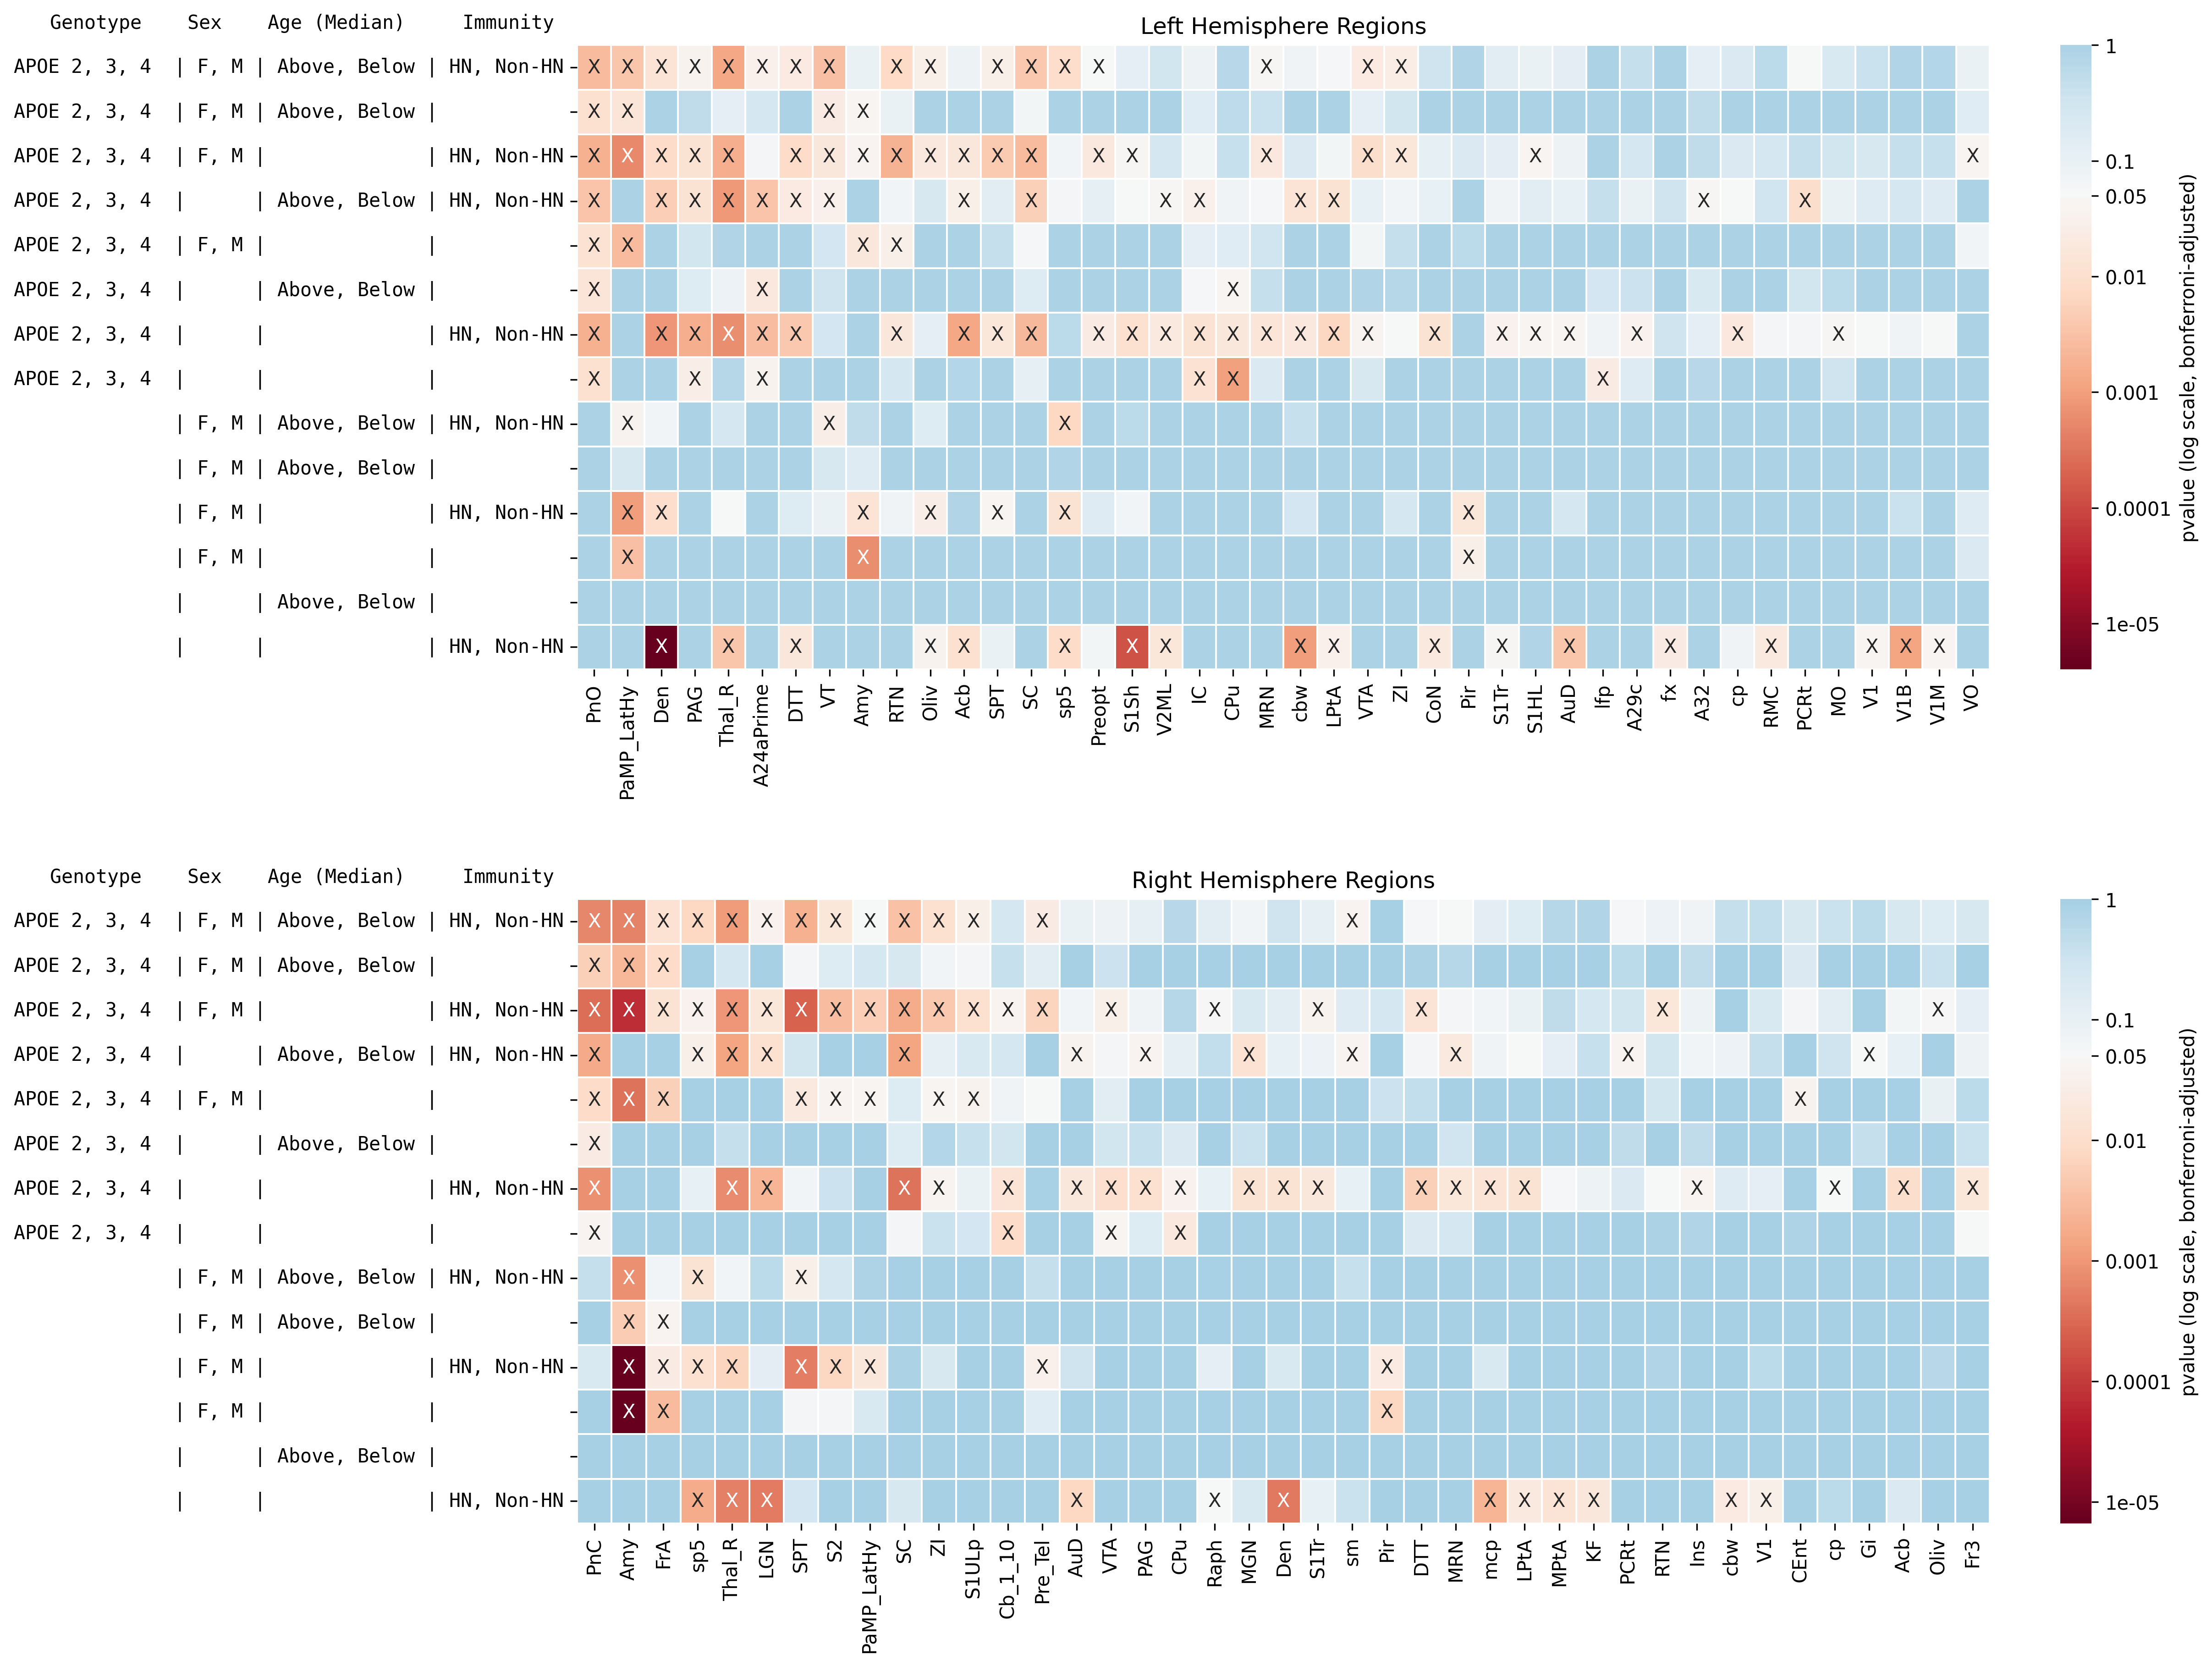

In [293]:
# rows_to_choose = np.arange(15)
rows_to_choose = [0, 1, 2, 3, 8, 9, 10, 23, 4, 11, 15, 24, 28, 32]

tmp = pvalues.iloc[rows_to_choose]

# pvalues.columns = node_labels["Abbreviation"].values
tmp.columns = node_labels["Abbreviation-Hemisphere"].values
# pvalues = pvalues[sorted(pvalues.columns)]


# resort cols
col_sort_idx = (tmp <= 0.05).sum().argsort().values[::-1]
tmp = tmp.iloc[:, col_sort_idx]

nodes_to_choose = ((tmp <= 0.05).sum() >= 1).values

left_idx = nodes_to_choose & left_nodes[col_sort_idx]
right_idx = nodes_to_choose & right_nodes[col_sort_idx]

fig = plt.figure(layout="constrained", figsize=(16, 12), dpi=300)
subfigs = fig.subfigures(2, 1, hspace=0.07)

left_axes = subfigs[0].subplots(1, 1)
right_axes = subfigs[1].subplots(1, 1)

for ax, nodes_to_choose, title in zip(
    [left_axes, right_axes],
    [left_idx, right_idx],
    ["Left Hemisphere Regions", "Right Hemisphere Regions"],
):
    sns.heatmap(
        tmp.transform("log10").iloc[:, nodes_to_choose],
        ax=ax,
        annot=mask[:, col_sort_idx][:, nodes_to_choose][rows_to_choose, :],
        fmt="",
        square=False,
        linewidths=0.5,
        center=np.log10(0.05),
        cbar_kws={"ticks": np.log10(cbar_ticks)},
        cmap="RdBu",
        # xticklabels=False,
    )
    ax.set_title(title)

    ax.collections[0].colorbar.set_label("pvalue (log scale, bonferroni-adjusted)")
    ax.collections[0].colorbar.set_ticklabels(cbar_ticks)
    ax.set_yticklabels(
        ax.get_yticklabels(), ha="right", fontdict={"family": "monospace"}
    )

    text_dict = dict(
        ha="right",
        va="bottom",
        transform=ax.transAxes,
        fontdict={"family": "monospace"},
    )

    bbox = ax.get_yticklabels()[0].get_window_extent()
    x, _ = ax.transAxes.inverted().transform([bbox.x0, bbox.y0])

    # ax.set_title(
    #     "K     N          Genotype     Sex    Age (Median)     Allele", x=0, **text_dict
    # )

    header = "Genotype    Sex    Age (Median)     Immunity  "

    ax.text(0, 1.02, header, **text_dict)
    # ax.set_xlabel("Brain Regions")

fig.savefig(
    f"../results/figures/allele_tests_significant_only.png",
    bbox_inches="tight",
    dpi=300,
)

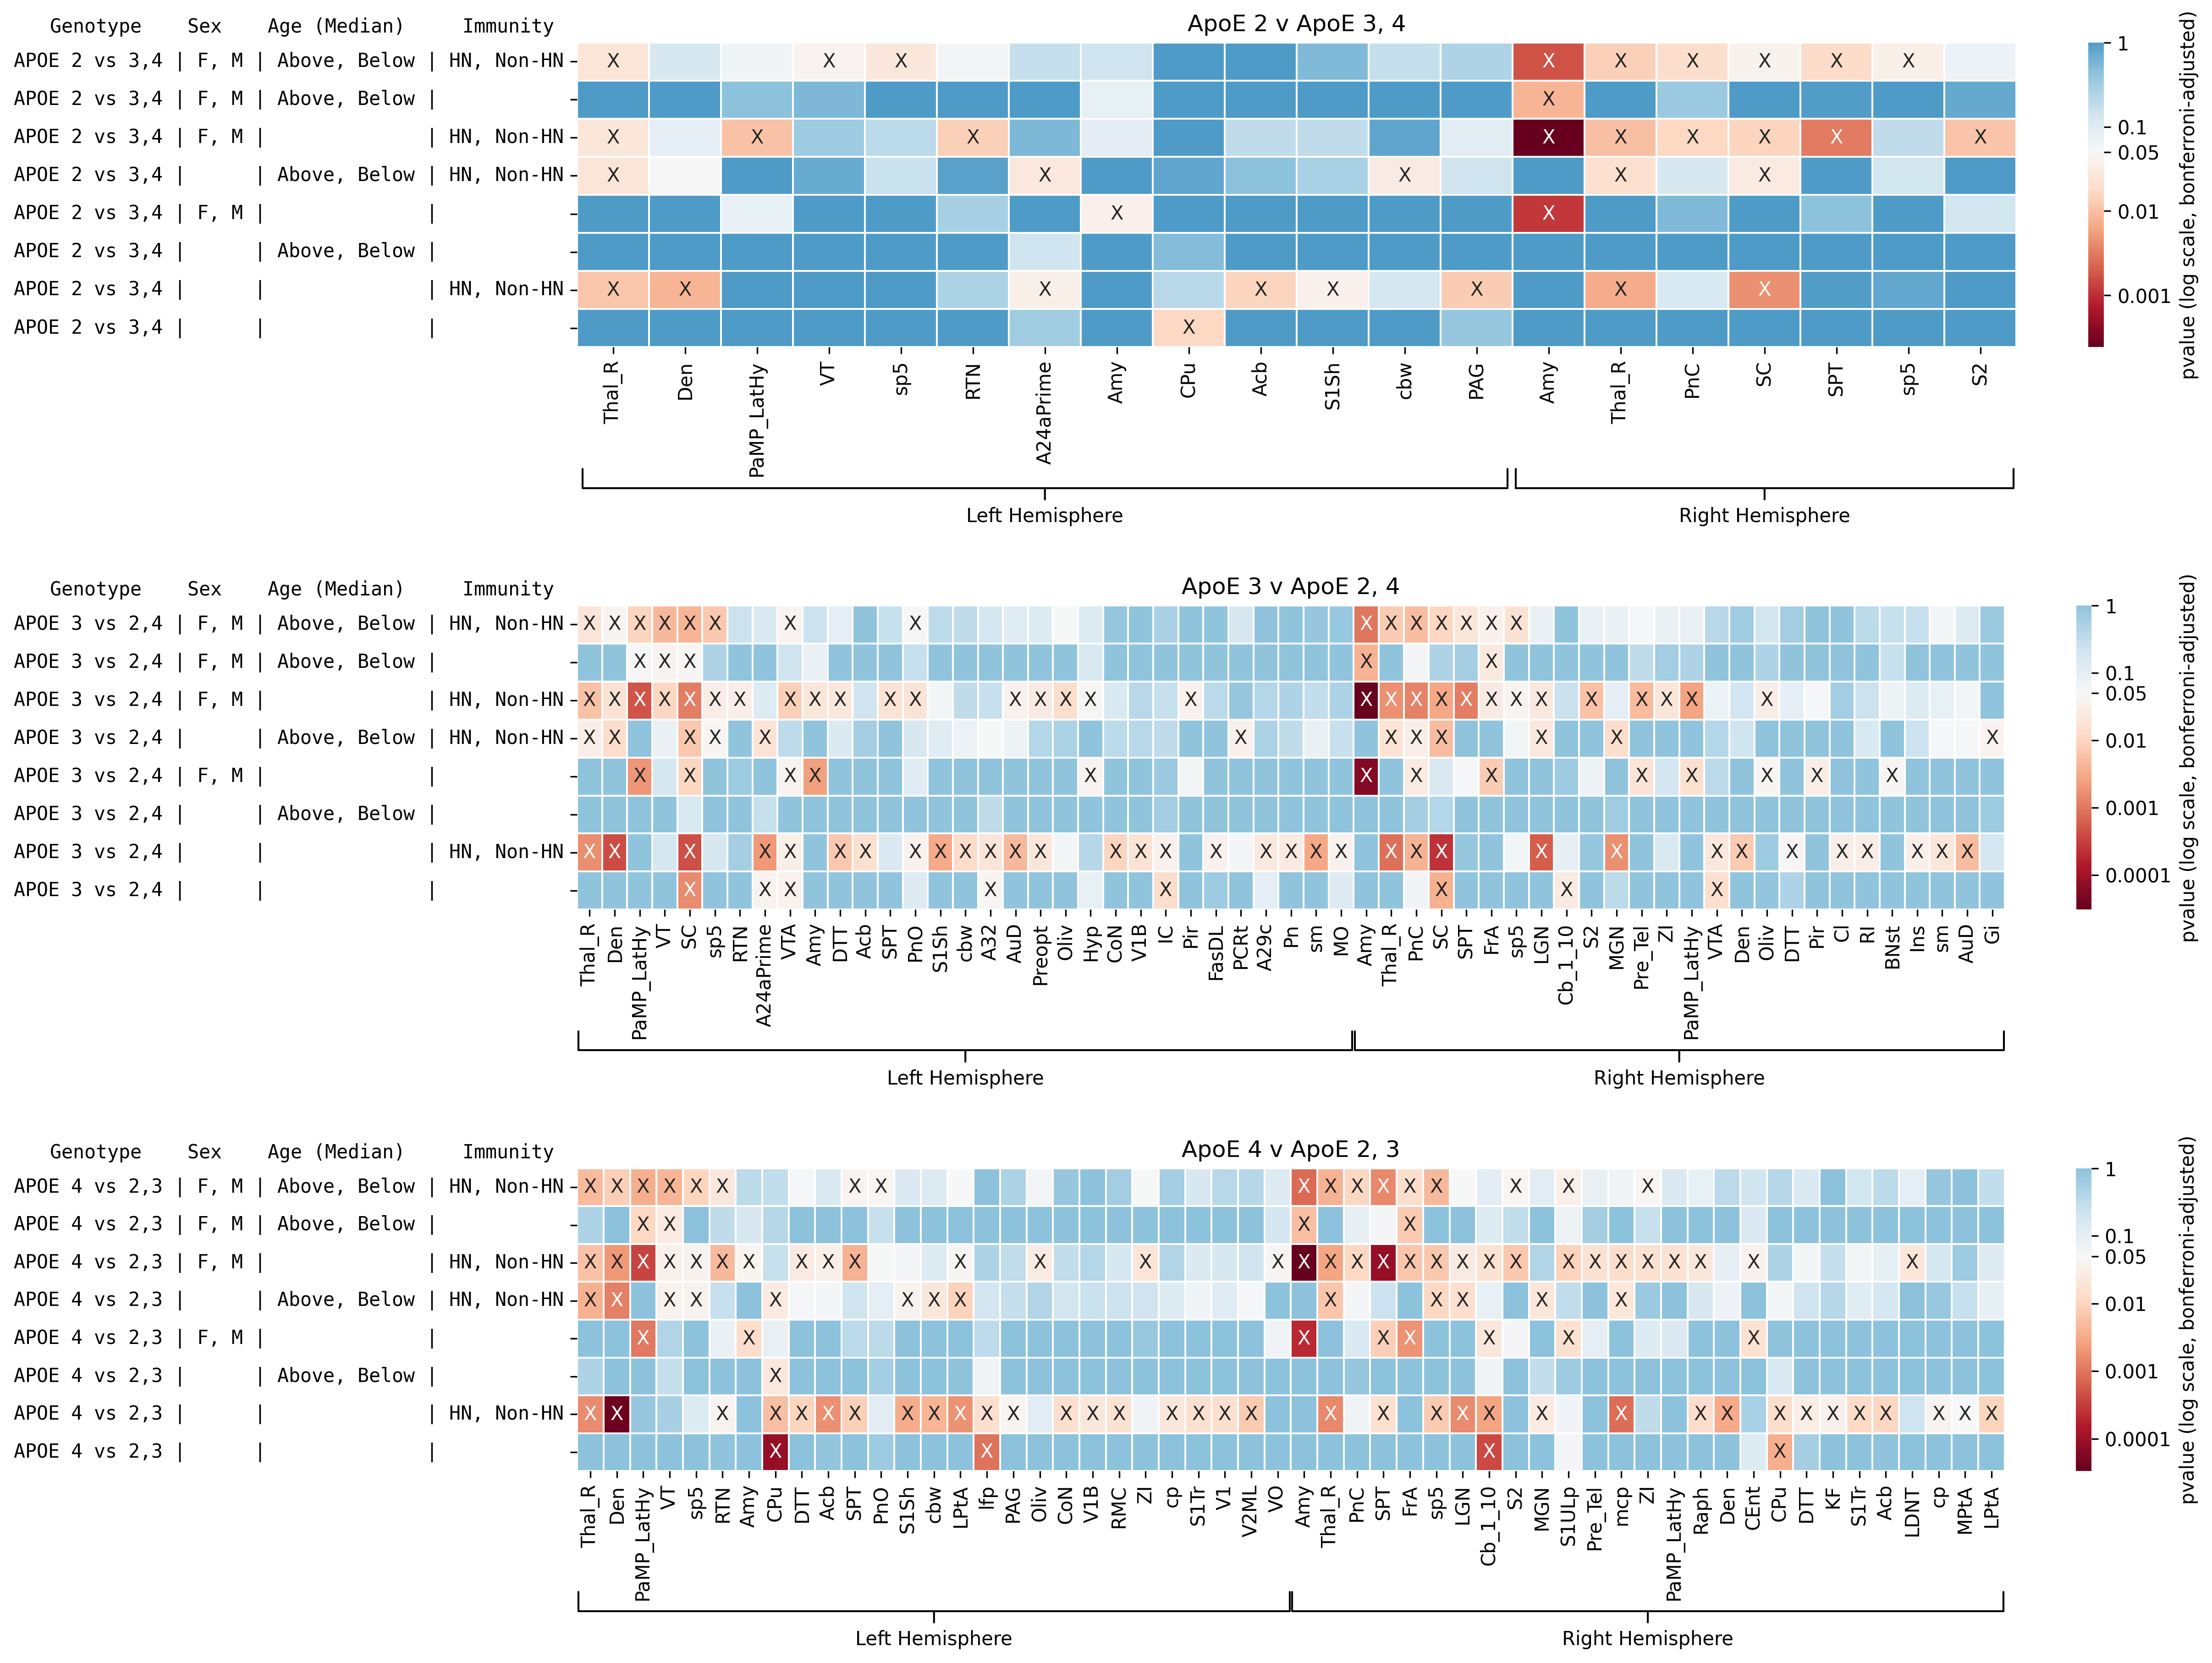

In [302]:
# rows_to_choose = np.arange(15)
rows_to_choose = np.arange(24)
pairwise_idx = df.loc[:, ["APOE34", "APOE24", "APOE23"]].any(axis=1).values
tmp = pvalues.iloc[pairwise_idx].iloc[rows_to_choose]

# resort cols
col_sort_idx = (tmp <= 0.05).sum().argsort().values[::-1]
tmp = tmp.iloc[:, col_sort_idx]

# resort rows and separate
resort_idx = np.arange(len(tmp))
resort_idx = [resort_idx[::3], resort_idx[1::3], resort_idx[2::3]]

tmps = [tmp.iloc[resort_idx[0]], tmp.iloc[resort_idx[1]], tmp.iloc[resort_idx[2]]]


fig = plt.figure(layout="constrained", figsize=(16, 12), dpi=300)
subfigs = fig.subfigures(3, 1, hspace=0.07)

top_axes = subfigs[0].subplots(1, 1)
mid_axes = subfigs[1].subplots(1, 1)
bot_axes = subfigs[2].subplots(1, 1)

for idx, ax, data, title in zip(
    [0, 1, 2],
    [top_axes, mid_axes, bot_axes],
    tmps,
    ["ApoE 2 v ApoE 3, 4", "ApoE 3 v ApoE 2, 4", "ApoE 4 v ApoE 2, 3"],
):
    nodes_to_choose = ((data <= 0.05).sum() >= 1).values

    left_idx = nodes_to_choose & left_nodes[col_sort_idx]
    right_idx = nodes_to_choose & right_nodes[col_sort_idx]

    # remake data and mask
    to_plot_data = pd.concat(
        [
            data.transform("log10").iloc[:, left_idx],
            data.transform("log10").iloc[:, right_idx],
        ],
        axis=1,
    )
    to_plot_mask = mask[:, col_sort_idx][pairwise_idx][resort_idx[idx]]
    to_plot_mask = np.hstack([to_plot_mask[:, left_idx], to_plot_mask[:, right_idx]])

    sns.heatmap(
        to_plot_data,
        ax=ax,
        annot=to_plot_mask,
        fmt="",
        square=False,
        linewidths=0.5,
        center=np.log10(0.05),
        cbar_kws={"ticks": np.log10(cbar_ticks)},
        cmap="RdBu",
        # xticklabels=False,
    )
    ax.set_title(title)
    # ax.set_xticklabels(ax.get_xticklabels, rotation=90)
    ax.tick_params(axis="x", labelrotation=90)

    ax.collections[0].colorbar.set_label("pvalue (log scale, bonferroni-adjusted)")
    ax.collections[0].colorbar.set_ticklabels(cbar_ticks)
    ax.set_yticklabels(
        ax.get_yticklabels(), ha="right", fontdict={"family": "monospace"}
    )

    text_dict = dict(
        ha="right",
        va="bottom",
        transform=ax.transAxes,
        fontdict={"family": "monospace"},
    )

    # bbox = ax.get_yticklabels()[0].get_window_extent()
    # x, _ = ax.transAxes.inverted().transform([bbox.x0, bbox.y0])

    # header = "Genotype    Sex    Age (Median)     Allele   "
    header = "Genotype    Sex    Age (Median)     Immunity  "

    ax.text(0, 1.02, header, **text_dict)

    # do the brackets
    total = nodes_to_choose.sum()
    left_total = left_idx.sum() / total
    left_mid = left_total / 2
    right_total = right_idx.sum() / total
    right_mid = right_total / 2

    total_points = 37.25
    y_point = -0.45
    y_text = -0.525
    lengthB = 1

    # do left hemi

    ax.annotate(
        "Left Hemisphere",
        xy=(left_mid, y_point),
        xytext=(left_mid, y_text),
        xycoords="axes fraction",
        ha="center",
        va="top",
        arrowprops=dict(
            arrowstyle=f"-[, widthB={left_total * total_points}, lengthB={lengthB}",
            lw=1.0,
        ),
    )

    ax.annotate(
        "Right Hemisphere",
        xy=(right_mid + left_total, y_point),
        xytext=(right_mid + left_total, y_text),
        xycoords="axes fraction",
        ha="center",
        va="top",
        arrowprops=dict(
            arrowstyle=f"-[, widthB={right_total * total_points}, lengthB={lengthB}",
            lw=1.0,
        ),
    )

fig.savefig(
    f"../results/figures/allele_tests_pairwise_significant_only.png",
    bbox_inches="tight",
    dpi=300,
)

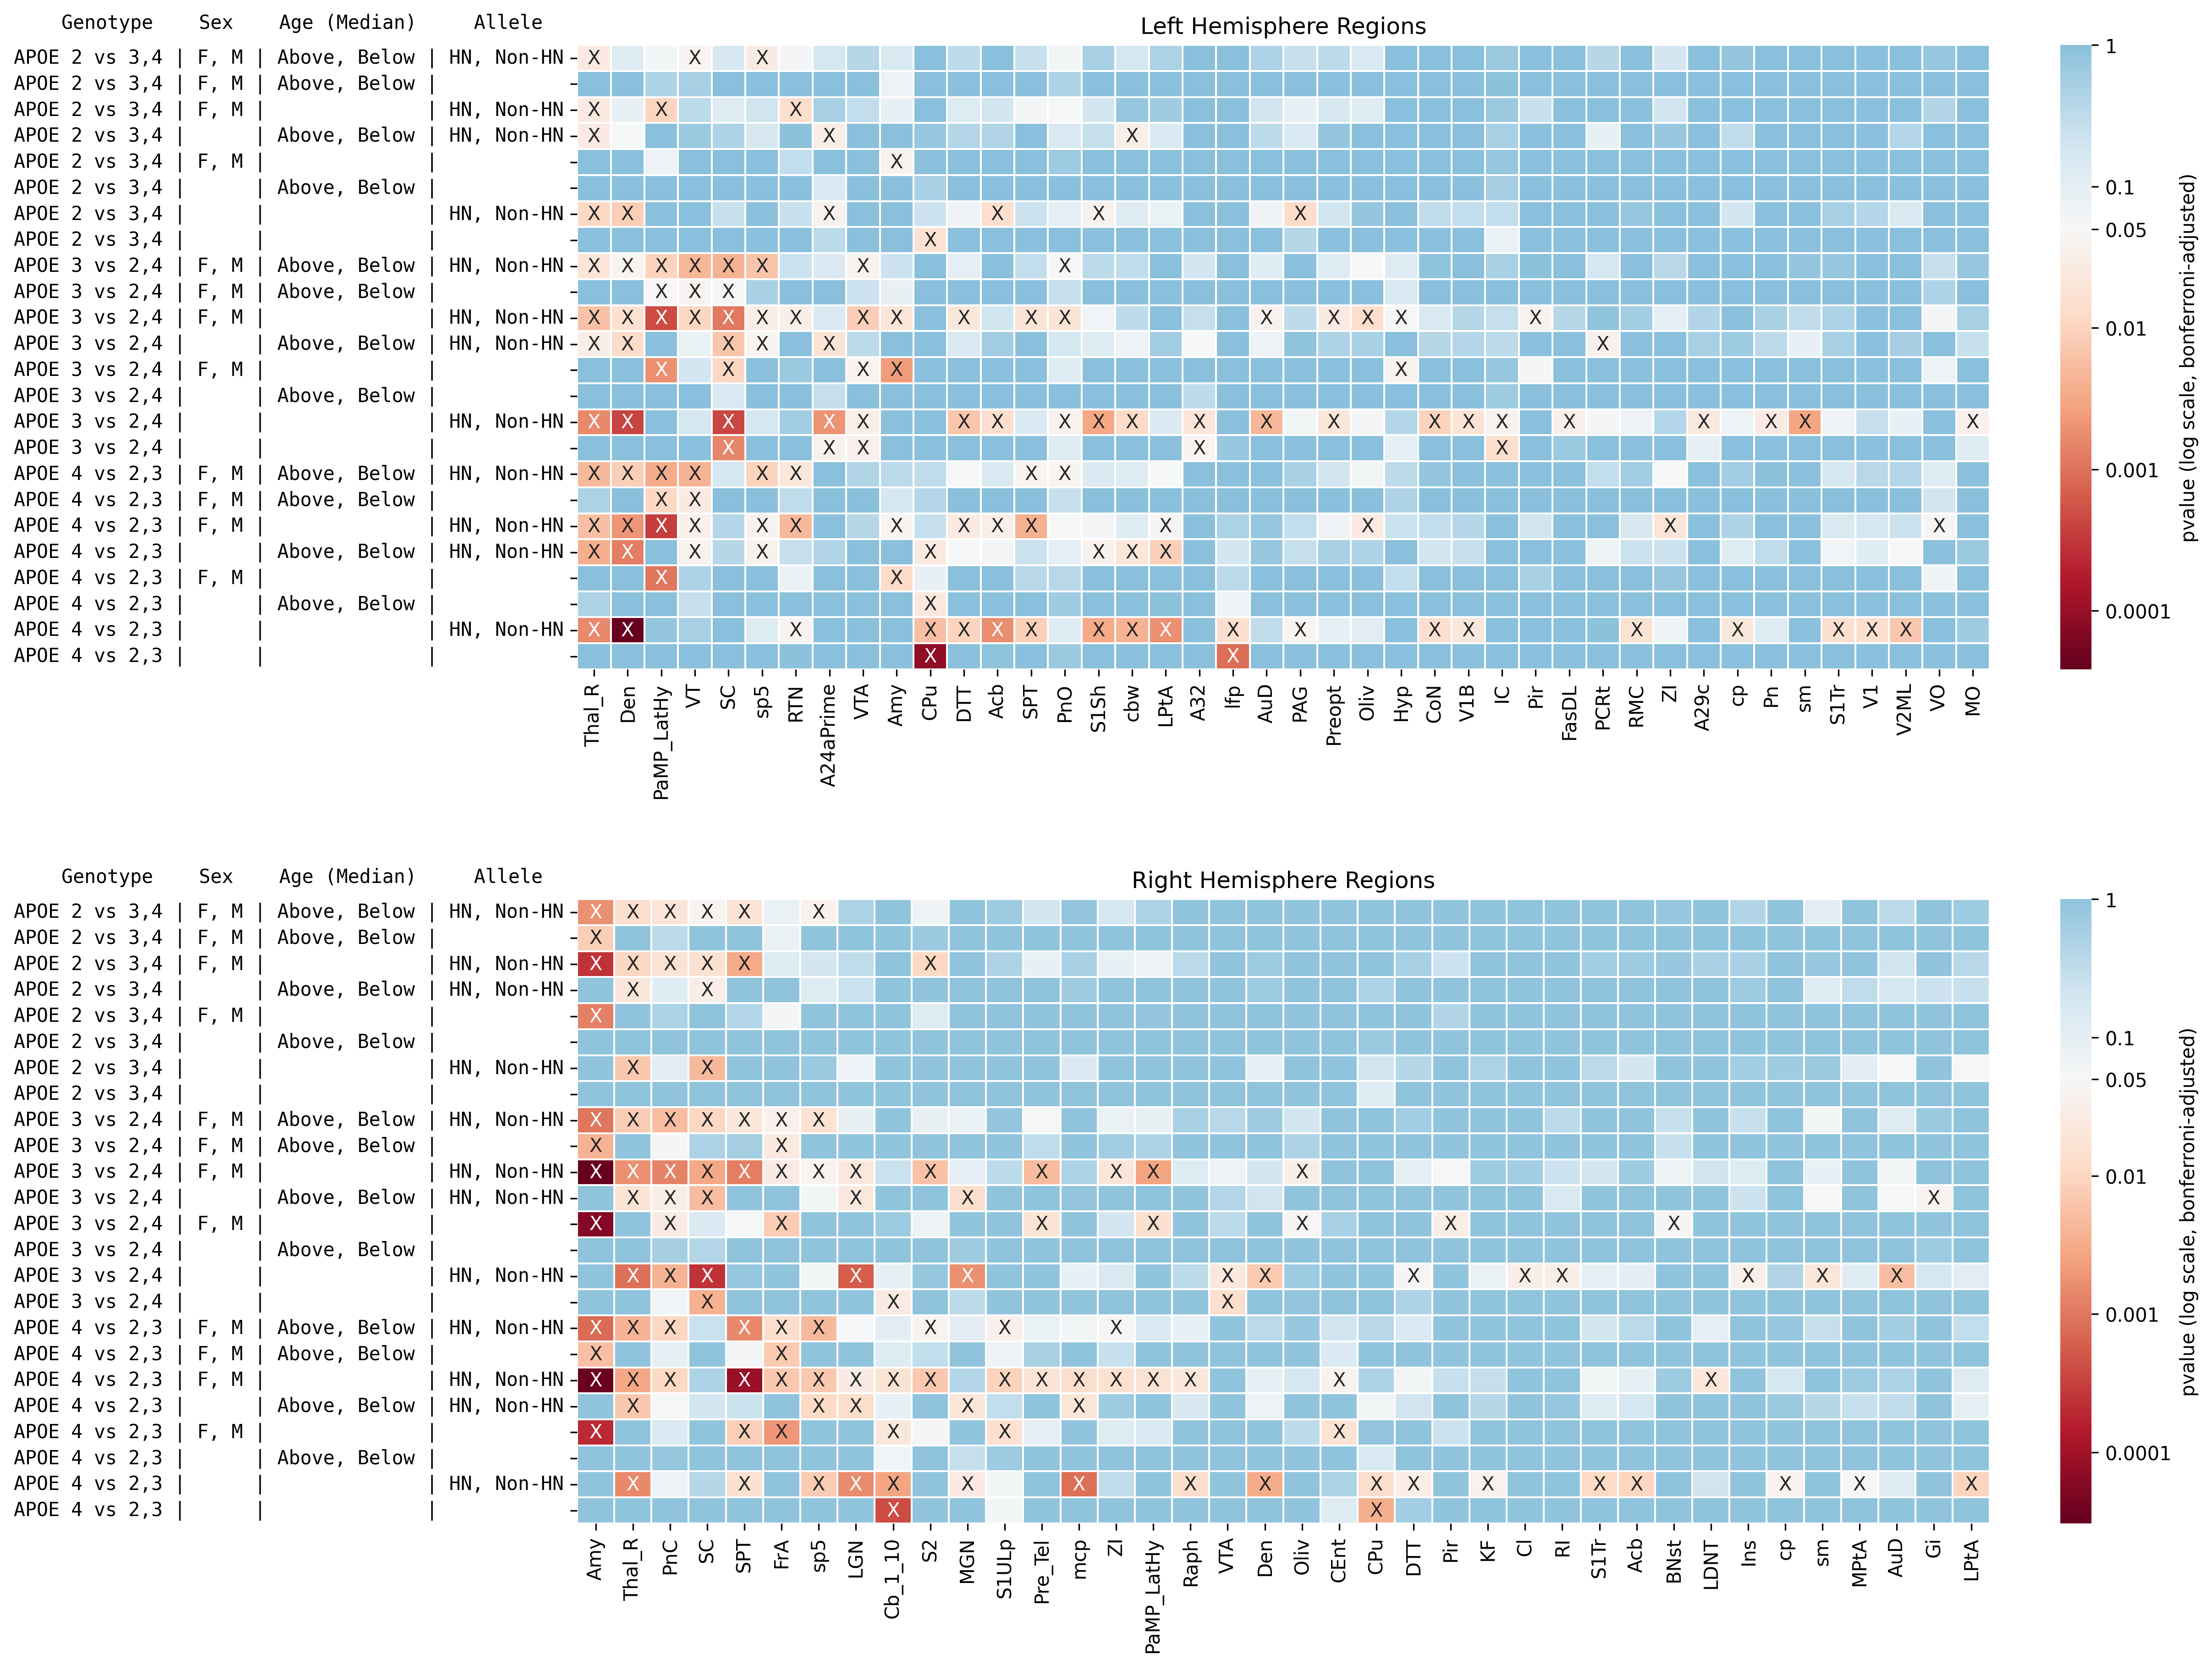

In [227]:
# rows_to_choose = np.arange(15)
rows_to_choose = np.arange(24)

pairwise_idx = df.loc[:, ["APOE34", "APOE24", "APOE23"]].any(axis=1).values
tmp = pvalues.iloc[pairwise_idx].iloc[rows_to_choose]

# resort
resort_idx = np.arange(len(tmp))
resort_idx = np.concatenate([resort_idx[::3], resort_idx[1::3], resort_idx[2::3]])
tmp = tmp.iloc[resort_idx]


# resort cols
col_sort_idx = (tmp <= 0.05).sum().argsort().values[::-1]
tmp = tmp.iloc[:, col_sort_idx]

nodes_to_choose = ((tmp <= 0.05).sum() >= 1).values

left_idx = nodes_to_choose & left_nodes[col_sort_idx]
right_idx = nodes_to_choose & right_nodes[col_sort_idx]


fig = plt.figure(layout="constrained", figsize=(16, 12), dpi=300)
subfigs = fig.subfigures(2, 1, hspace=0.07)

left_axes = subfigs[0].subplots(1, 1)
right_axes = subfigs[1].subplots(1, 1)

for ax, nodes_to_choose, title in zip(
    [left_axes, right_axes],
    [left_idx, right_idx],
    ["Left Hemisphere Regions", "Right Hemisphere Regions"],
):
    sns.heatmap(
        tmp.transform("log10").iloc[rows_to_choose, nodes_to_choose],
        ax=ax,
        annot=mask[:, col_sort_idx][pairwise_idx][:, nodes_to_choose][
            rows_to_choose, :
        ][resort_idx],
        fmt="",
        square=False,
        linewidths=0.5,
        center=np.log10(0.05),
        cbar_kws={"ticks": np.log10(cbar_ticks)},
        cmap="RdBu",
        # xticklabels=False,
    )
    ax.set_title(title)

    ax.collections[0].colorbar.set_label("pvalue (log scale, bonferroni-adjusted)")
    ax.collections[0].colorbar.set_ticklabels(cbar_ticks)
    ax.set_yticklabels(
        ax.get_yticklabels(), ha="right", fontdict={"family": "monospace"}
    )

    text_dict = dict(
        ha="right",
        va="bottom",
        transform=ax.transAxes,
        fontdict={"family": "monospace"},
    )

    bbox = ax.get_yticklabels()[0].get_window_extent()
    x, _ = ax.transAxes.inverted().transform([bbox.x0, bbox.y0])

    # ax.set_title(
    #     "K     N          Genotype     Sex    Age (Median)     Allele", x=0, **text_dict
    # )

    header = "Genotype    Sex    Age (Median)     Allele   "
    ax.text(0, 1.02, header, **text_dict)
    # ax.set_xlabel("Brain Regions")

fig.savefig(
    f"../results/figures/allele_tests_pairwise_significant_only.png",
    bbox_inches="tight",
    dpi=300,
)

In [427]:
regions = []
idxes = []

for idx, row in tmp.iterrows():
    row = row[row <= 0.05]
    regions.append(list(np.argsort(row)[:5].index))

    idxes.append(idx)

regions = pd.DataFrame([regions[0]] + regions[-4:-1] + [regions[-1]])

regions = regions.T

regions.columns = ["Genotype+Sex+Age+Allele", "Genotype", "Sex", "Age", "Allele"]

In [428]:
for idx, row in regions.iterrows():
    for key, val in row.items():
        if val is None:
            continue
        splits = val.split("-")
        if splits[1] == "L":
            hemi = "Left"
        else:
            hemi = "Right"
        new_val = node_labels[
            (node_labels.Abbreviation == splits[0]) & (node_labels.Hemisphere == hemi)
        ].Structure.iloc[0]
        new_val = new_val + "-" + splits[1]
        new_val = new_val.replace("_", " ")
        row[key] = new_val

In [431]:
regions

,Genotype+Sex+Age+Allele,Genotype,Sex,Age,Allele
0,Cingulate Cortex Area 24a prime-L,Cingulate Cortex Area 24a prime-L,Piriform Cortex-L,None,Secondary Auditory Cortex Dorsal Part-L
1,Lateral Parietal Association Cortex-L,Striatum-L,Amygdala-L,None,Lateral Parietal Association Cortex-L
2,Primary Somatosensory Cortex Hindlimb Region-L,Periaquaductal Grey-L,PosteriorDorsal ParaventricularMedialParvicell...,None,Primary Somatosensory Cortex Shoulder Region-L
3,Primary Somatosensory Cortex Shoulder Region-L,Inferior Colliculus-L,Frontal Association Cortex-R,None,Primary Somatosensory Cortex Trunk Region-L
4,Primary Somatosensory Cortex Trunk Region-L,Pontine Reticular NucleusOral-L,Secondary Somatosensory Cortex-R,None,Primary Visual Cortex-L


In [430]:
print(regions.to_latex())

\begin{tabular}{llllll}
\toprule
{} &                         Genotype+Sex+Age+Allele &                           Genotype &                                                Sex &   Age &                                          Allele \\
\midrule
0 &               Cingulate Cortex Area 24a prime-L &  Cingulate Cortex Area 24a prime-L &                                  Piriform Cortex-L &  None &         Secondary Auditory Cortex Dorsal Part-L \\
1 &           Lateral Parietal Association Cortex-L &                         Striatum-L &                                         Amygdala-L &  None &           Lateral Parietal Association Cortex-L \\
2 &  Primary Somatosensory Cortex Hindlimb Region-L &              Periaquaductal Grey-L &  PosteriorDorsal ParaventricularMedialParvicell... &  None &  Primary Somatosensory Cortex Shoulder Region-L \\
3 &  Primary Somatosensory Cortex Shoulder Region-L &              Inferior Colliculus-L &                       Frontal Association Cortex-R &  

/tmp/ipykernel_45976/2394722967.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(regions.to_latex())
